In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from common.read_COMSOL_data import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
CURR_PATH = os.getcwd()
DATA_PATH = os.path.join(CURR_PATH, 'data')

(-5, 5)

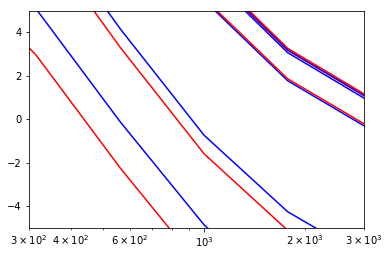

In [8]:
d1d2_file_path = os.path.join(DATA_PATH, '20171022_d1d2_cdt_vs_bias_result_real.csv')
import pandas as pd
d1d2_data = pd.read_csv(d1d2_file_path)
d1d2_data = d1d2_data.set_index('bias')

exp_data_path = os.path.join(DATA_PATH, '20171023_dw6_real.csv')
exp_data = pd.read_csv(exp_data_path, names = ['bias', 'dw', 'd1', 'd2', 'dw-d1', 'dw-d2'])
exp_data = exp_data.set_index('bias')

from common.data_analysis import from_y_to_x

dw_cdt_vs_bias = pd.DataFrame()

# DW #1 False, #2 True, #3 False, #4 True, #6 True
exchange_d1d2 = True

for some_bias in [2, 1, 0, -1, -2]:
    # DW simulation
    some_file_name = "20171022_lfo_dw_{}V_sim_data_3d_real.csv".format(some_bias)
    some_file_path = os.path.join(DATA_PATH, some_file_name)
    some_data = read_COMSOL_csv(some_file_path, name_list=['cdt', 'y21_imag', 'y21_real'])
    # Domain simulation
    single_domain_file_path = os.path.join(DATA_PATH, '20171022_lfo_sim_data_3d.csv')
    single_domain_data = read_COMSOL_csv(single_domain_file_path, name_list=['tip_curv', 'cdt', 'freq', 'y21_imag', 'y21_real'])
    tip_curv = 300
    freq = 1e9
    conditions= {'tip_curv': tip_curv, 'freq': freq}
    single_domain_data_selected = get_sub_dataframe(single_domain_data, conditions=conditions)
    # Discrete points to curves for domain simulation
    cdt_sd = single_domain_data_selected['cdt'].values
    imag_sd = -1 * single_domain_data_selected['y21_imag'].values
    real_sd = -1 * single_domain_data_selected['y21_real'].values
    curve_imag_sd = InterpolatedUnivariateSpline(cdt_sd, imag_sd)
    curve_real_sd = InterpolatedUnivariateSpline(cdt_sd, real_sd)
    # Assign domain cdts
    some_cdt1 = d1d2_data.loc[some_bias, 'cdt1']
    some_cdt2 = d1d2_data.loc[some_bias, 'cdt2']
    # Get re signal level for domains
    some_d1_real = curve_real_sd(some_cdt1)
    some_d2_real = curve_real_sd(some_cdt2)
    # Get DW - Domain signal level vs dw cdt
    cdt = some_data['cdt'].values
    diff_dw_d1_real = -1 * some_data['y21_real'].values - some_d1_real
    diff_dw_d2_real = -1 * some_data['y21_real'].values - some_d2_real
    
    exp_1 = exp_data.loc[some_bias, 'dw-d1']
    exp_2 = exp_data.loc[some_bias, 'dw-d2']
    
    delta_1 = exp_1 / 4.4
    delta_2 = exp_2 / 4.4
    
    if exchange_d1d2:
        dw_cdt_1 = from_y_to_x(cdt, diff_dw_d2_real, delta_1, 500)
        dw_cdt_2 = from_y_to_x(cdt, diff_dw_d1_real, delta_2, 500)
    else:
        dw_cdt_1 = from_y_to_x(cdt, diff_dw_d1_real, delta_1, 500)
        dw_cdt_2 = from_y_to_x(cdt, diff_dw_d2_real, delta_2, 500)
    
    dw_cdt_vs_bias.loc[some_bias, 'cdt1'] = dw_cdt_1
    dw_cdt_vs_bias.loc[some_bias, 'cdt2'] = dw_cdt_2
    
    plt.plot(cdt, diff_dw_d1_real, 'b-', cdt, diff_dw_d2_real, 'r-')

plt.xscale('log')
plt.xlim([300, 3000])
plt.ylim([-5,5])
# plt.plot(dw_cdt_vs_bias.index.values, dw_cdt_vs_bias['cdt1'], 'b-', dw_cdt_vs_bias.index.values, dw_cdt_vs_bias['cdt2'], 'r-')

In [4]:
dw_cdt_vs_bias['avg_cdt'] = (dw_cdt_vs_bias['cdt1'] + dw_cdt_vs_bias['cdt2']) / 2.0

In [5]:
dw_cdt_vs_bias

,cdt1,cdt2,avg_cdt
2,2261.567399,2202.915961,2232.241680
1,2440.845849,2496.881702,2468.863775
0,1991.228128,1962.395437,1976.811782
-1,760.836791,722.863497,741.850144
-2,449.119781,447.976183,448.547982
